# ID5059 Project 2, April, 2022

## Group: Experiencing A Significant Gravitas Shortfall

This is the Jupyter notebook documenting our team's final solution for the [Kaggle IEEE-CIS Fraud Detection](https://www.kaggle.com/competitions/ieee-fraud-detection) Project. The workflow of our solution is largely inspired by the Appendix in the Machine Learning Textbook by Aurélien Géron. The structure of this notebook will be organized as follows:

<ol>
    <li> Understand the problem </li>
    <li> Get the data </li>
    <li> Exploratory Data Analysis (EDA) and Feature Engineering (FE) </li>
    <li> Explore Models </li>
    <li> Fine-tune Model</li>
    <li> Present solution </li>
</ol>


In [1]:
# including all necessary libaries
import pandas as pd 
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import datetime
from time import time

# plotting style
plt.style.use('ggplot')
color_pal = [x['color'] for x in plt.rcParams['axes.prop_cycle']]
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import KFold, TimeSeriesSplit, StratifiedKFold
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.decomposition import PCA, KernelPCA
from sklearn.model_selection import GridSearchCV
import lightgbm as lgb 

In [2]:
def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

In [3]:
# helpher function for pre-processing identity 
# https://www.kaggle.com/code/davidcairuz/feature-engineering-lightgbm
# https://www.kaggle.com/code/kabure/almost-complete-feature-engineering-ieee-data#Id-datasets
def id_process(dataframe):
    
    # derive device name and version 
    dataframe['DeviceInfo'] = dataframe['DeviceInfo'].fillna('unknown_device').str.lower()
    dataframe['device_name'] = dataframe['DeviceInfo'].str.split('/', expand=True)[0]
    dataframe['device_version'] = dataframe['DeviceInfo'].str.split('/', expand=True)[1]
    
    # natural for these NaN to be imputed as unknown
    dataframe['id_31'] = dataframe['id_31'].fillna('unknown_device').str.lower()
    dataframe['id_15'].fillna('Unknown', inplace=True)

    # derive browser version
    dataframe['browser_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[0]
    dataframe['version_id_31'] = dataframe['id_31'].str.split(' ', expand=True)[1]

    # device renaming, sum together common manufacturer
    dataframe.loc[dataframe['device_name'].str.contains('SM', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('sm-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('samsung', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('SAMSUNG', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('GT-', na=False), 'device_name'] = 'Samsung'
    dataframe.loc[dataframe['device_name'].str.contains('Moto G', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('Moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('moto', na=False), 'device_name'] = 'Motorola'
    dataframe.loc[dataframe['device_name'].str.contains('LG-', na=False), 'device_name'] = 'LG'
    dataframe.loc[dataframe['device_name'].str.contains('rv:', na=False), 'device_name'] = 'RV'
    dataframe.loc[dataframe['device_name'].str.contains('HUAWEI', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ALE-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('ale-', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('-L', na=False), 'device_name'] = 'Huawei'
    dataframe.loc[dataframe['device_name'].str.contains('Blade', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('BLADE', na=False), 'device_name'] = 'ZTE'
    dataframe.loc[dataframe['device_name'].str.contains('Linux', na=False), 'device_name'] = 'Linux'
    dataframe.loc[dataframe['device_name'].str.contains('XT', na=False), 'device_name'] = 'Sony'
    dataframe.loc[dataframe['device_name'].str.contains('HTC', na=False), 'device_name'] = 'HTC'
    dataframe.loc[dataframe['device_name'].str.contains('ASUS', na=False), 'device_name'] = 'Asus'

    dataframe.loc[dataframe.device_name.isin(dataframe.device_name.value_counts()[dataframe.device_name.value_counts() < 200].index), 'device_name'] = "Others"
    
    return dataframe

In [4]:
# helper function for imputing transaction NaNs
def impute_tran(df):
    cate_cols = df.select_dtypes('string').columns
    num_cols = df.columns[~df.columns.isin(cate_cols)]

    # numerical using median
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    # categorical explicit use str 'None'
    df[cate_cols] = df[cate_cols].fillna('None')

    return df

# helper function for imputinh identity NaNs
def impute_id(df, num_cols, cate_cols):
    df[num_cols] = df[num_cols].fillna(df[num_cols].median())
    
    for col in cate_cols:
        df[col].fillna('None', inplace = True)
    
    return df

In [5]:
# grid search hyperparameters given a parameter grid, 5-fold cv
def algorithm_pipeline(X_train_data, X_test_data, y_train_data, y_test_data,
                       model, param_grid, cv=5, scoring_fit='roc_auc'):

    gs = GridSearchCV(
        estimator=model,
        param_grid=param_grid,
        cv=cv,
        n_jobs=-1,
        scoring=scoring_fit,
        verbose=2
    )
    fitted_model = gs.fit(X_train_data, y_train_data)

    pred = fitted_model.predict_proba(X_test_data)

    return fitted_model, pred

In [6]:
# use stratified k-fold to cross-validate tuned hyperparameters for lightGBMC
# https://www.kaggle.com/code/nroman/lgb-single-model-lb-0-9419
def train_lgb(X, y):

    N_SPLITS = 5
    skf = StratifiedKFold(n_splits=N_SPLITS)

    aucs = list()

    feature_importances = pd.DataFrame()
    feature_importances['feature'] = X.columns

    training_start_time = time()

    for fold, (trn_idx, test_idx) in enumerate(skf.split(X, y)):
        start_time = time()
        print('Training on fold {}'.format(fold + 1))

        trn_data = lgb.Dataset(X.iloc[trn_idx], label=y.iloc[trn_idx])
        val_data = lgb.Dataset(X.iloc[test_idx], label=y.iloc[test_idx])
        
        clf = lgb.train(params, trn_data, 10000, valid_sets=[
                        trn_data, val_data], verbose_eval=500, early_stopping_rounds=200) #es: 500->300->200
        
        feature_importances['fold_{}'.format(
            fold + 1)] = clf.feature_importance()
        
        aucs.append(clf.best_score['valid_1']['auc'])
        print('Fold {} finished in {}'.format(
            fold + 1, str(datetime.timedelta(seconds=time() - start_time))))

    print('-' * 50)
    print('Training has finished')
    print('Total training time is {}'.format(
        str(datetime.timedelta(seconds=time() - training_start_time))))
    print('Mean AUC:', np.mean(aucs))
    print('-' * 50)
    
    feature_importances['average'] = feature_importances[['fold_{}'.format(fold + 1) for fold in range(skf.n_splits)]].mean(axis=1)
#     feature_importances.to_csv('feature_importances.csv')
    plt.figure(figsize=(16, 16))
    sns.barplot(data=feature_importances.sort_values(by='average', ascending=False).head(30), x='average', y='feature');
    plt.title('30 TOP feature importance over {} folds average'.format(skf.n_splits));
    
    best_iter = clf.best_iteration
    clf = lgb.LGBMClassifier(**params, num_boost_round=best_iter)
    return clf

# 1. Understand the problem

<ol>
    <li> <b>Understand the problem</b> </li>
    <li> Get the data </li>
    <li> EDA and FE </li>
    <li> Explore Models </li>
    <li> Fine-tune Model</li>
    <li> Present solution </li>
</ol>

- How is a transaction classified as fraud or legitimate
- This is a ML project from Kaggle, there is definitely profit incentives among businesses to prevent frauds

This is clearly a classification problem, since the label/outcome/response is whether or not the transaction is fraud.

Later a few models will be built and have predictions, $\hat{\mathbf{y}}$, and known values, $\mathbf{y}$

The predictions depend on a particular model, $f$, which is a simplified version of the observations that (hopefully) removes noise from the data, leaving a robust signal.

# 2. Get the data

<ol>
    <li> Understand the problem </li>
    <li> <b>Get the data</b> </li>
    <li> EDA and FE </li>
    <li> Explore Models </li>
    <li> Fine-tune Model</li>
    <li> Present solution </li>
</ol>

The <b>IEEE-CIS Fraud</b> data can be downloaded from [Kaggle](https://www.kaggle.com/competitions/ieee-fraud-detection/data) and saved as a few local .csv files that can be read as a pandas dataframe from this working directory. 

In [7]:
train_identity = pd.read_csv('train_identity.csv')
test_identity = pd.read_csv('test_identity.csv')
train_transaction = pd.read_csv('train_transaction.csv')
test_transaction = pd.read_csv('test_transaction.csv')

In [8]:
# reduce memory usage
train_transaction = reduce_mem_usage(train_transaction)
test_transaction = reduce_mem_usage(test_transaction)
train_identity = reduce_mem_usage(train_identity)
test_identity = reduce_mem_usage(test_identity)

Memory usage of dataframe is 1775.15 MB
Memory usage after optimization is: 542.35 MB
Decreased by 69.4%
Memory usage of dataframe is 1519.24 MB
Memory usage after optimization is: 472.59 MB
Decreased by 68.9%
Memory usage of dataframe is 45.12 MB
Memory usage after optimization is: 25.86 MB
Decreased by 42.7%
Memory usage of dataframe is 44.39 MB
Memory usage after optimization is: 25.44 MB
Decreased by 42.7%


# 3. EDA and FE

<ol>
    <li> Understand the problem </li>
    <li> Get the data </li>
    <li> <b>EDA and FE</b> </li>
    <li> Explore Models </li>
    <li> Fine-tune Model</li>
    <li> Present solution </li>
</ol>

Simple exploratory data analysis and group feature engineering efforts<br>

In [9]:
train_identity.shape, test_identity.shape

((144233, 41), (141907, 41))

In [10]:
train_transaction.shape, test_transaction.shape

((590540, 394), (506691, 393))

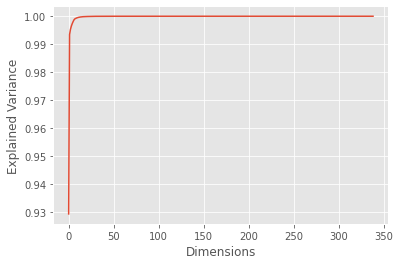

target_dimension after PCA: 2


In [12]:
# pca on v features of transaction data
vcols = [f'V{i}' for i in range(1, 340)]

pca = PCA()
pca.fit(train_transaction[vcols].fillna(-1))
plt.ylabel('Explained Variance')
plt.xlabel('Dimensions')
plt.plot(np.add.accumulate(pca.explained_variance_ratio_))
plt.show()

# maintaining 99% of variance
pca = PCA(n_components=0.99)
vcol_pca = pca.fit_transform(train_transaction[vcols].fillna(-1))
print("target_dimension after PCA:", vcol_pca.ndim)

Observe: <br>

As the number of dimensions increases, we do not see the variance explained increase in any meaningful manner after 2 features. Hence, dimension = 2 is effectively the 'elbow point' and we will perform PCA later setting the target dimension = 2. 

In [13]:
# understand which v features contributed the most for the pca-ed column
df_pca = pd.DataFrame(pca.components_,columns=vcols,index = ['PC-1','PC-2']).abs()
df_pca.idxmax(axis=1)

PC-1    V160
PC-2    V307
dtype: object

In [14]:
# make test identity having the same column names as train indentity
test_identity.columns = train_identity.columns.values.tolist()

In [15]:
id_cols = list(train_identity.columns.values)
trn_cols = list(train_transaction.drop('isFraud', axis=1).columns.values)

In [16]:
X_train = pd.merge(train_transaction[trn_cols + ['isFraud']], train_identity[id_cols], how='left')
X_test = pd.merge(test_transaction[trn_cols], test_identity[id_cols], how='left')

In [17]:
all_data = X_train.append(X_test, sort=False).reset_index(drop=True)

In [18]:
# performing PCA on joined train & test data
# https://www.kaggle.com/code/plasticgrammer/ieee-cis-fraud-detection-eda/notebook
vcols = [f'V{i}' for i in range(1,340)]

sc = MinMaxScaler()

pca = PCA(n_components=2)
vcol_pca = pca.fit_transform(sc.fit_transform(all_data[vcols].fillna(-1)))

all_data['_vcol_pca_0'] = vcol_pca[:,0]
all_data['_vcol_pca_1'] = vcol_pca[:,1]
all_data['_vcol_nulls'] = all_data[vcols].isnull().sum(axis=1)

all_data.drop(vcols, axis=1, inplace=True)

In [19]:
X_train = all_data[all_data['isFraud'].notnull()]
X_test = all_data[all_data['isFraud'].isnull()].drop('isFraud', axis=1)

In [20]:
# streamline workflow, keep as checkpoint
X_train.to_pickle("pca_train.pkl")
X_test.to_pickle("pca_test.pkl")

In [21]:
train = pd.read_pickle('pca_train.pkl')
test = pd.read_pickle('pca_test.pkl')

In [22]:
train = reduce_mem_usage(train)
test = reduce_mem_usage(test)

Memory usage of dataframe is 232.03 MB
Memory usage after optimization is: 223.02 MB
Decreased by 3.9%
Memory usage of dataframe is 195.22 MB
Memory usage after optimization is: 190.39 MB
Decreased by 2.5%


In [23]:
data_null = train.isnull().sum()/len(train) * 100
data_null = data_null.drop(data_null[data_null == 0].index).sort_values(ascending=False)[:500]
missing_data = pd.DataFrame({'Missing Ratio': data_null})
cols_drop = missing_data[missing_data['Missing Ratio'] > 90].index.values.tolist()

# remove columns with more than 90% missing values
train = train.drop(columns=cols_drop)
test = test.drop(columns=cols_drop)

print("features dropped due to high % of missing values", cols_drop)

features dropped due to high % of missing values ['id_24', 'id_25', 'id_07', 'id_08', 'id_21', 'id_26', 'id_23', 'id_22', 'id_27', 'dist2', 'D7', 'id_18']


In [24]:
transaction_cat_columns = ['ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1',
                           'addr2', 'P_emaildomain', 'R_emaildomain', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9']

In [25]:
train[transaction_cat_columns] = train[transaction_cat_columns].astype('string')
test[transaction_cat_columns] = test[transaction_cat_columns].astype('string')
transaction_cat = train.select_dtypes('string')

In [26]:
# Calculating the correlation of missing (nan) values
# Ignore columns that have no null entries
no_null_cat = transaction_cat.iloc[:, [i for i, n in enumerate(np.var(transaction_cat.isnull(), axis='rows')) if n > 0]]
null_corr = no_null_cat.isnull().corr()

In [27]:
# Only get the pair of correlations that are above a certain threshold
def get_high_corr_pairs(df, threshold):
    correlations = set()
    labels = df.columns

    for i in range(len(labels)):
        for j in range(i):
            if i == j:
                continue

            if df.iloc[i,j] >= threshold:
                correlations.add(frozenset([labels[i],labels[j]]))
    
    return correlations

In [28]:
# Get the pair of variables that have a direct correlation in their nulls,
# meaning when variable A is null, variable B is null and vice versa.
null_pairs = get_high_corr_pairs(null_corr, 1)

In [29]:
# Join the related sets together
def combine_sets(sets):
    combined_sets = [] 

    for this_set in sets:
        has_combined = False
        
        for combined_set in combined_sets:
            #If there exists a set that contains one of the elements, then combine
            if not this_set.isdisjoint(combined_set):
                combined_set.update(this_set)
                has_combined = True
                break
        
        if not has_combined:
            combined_sets.append(set(this_set))
            
    return combined_sets

In [30]:
combined_null_pairs = combine_sets(null_pairs)

In [31]:
# Combines categorical columns as strings. If any of the columns are null, then replace it with 'None'
def combine_columns(df, columns_to_combine):
    new_columns = []
    for columns in columns_to_combine:
        # Get the columns as a sorted list to index the df with and have a consistent name for the column
        columns = sorted(list(columns))
        new_column = ' '.join(columns)

        new_columns.append(new_column)

        df[new_column] = df[columns[0]].str.cat(df[columns[1:]], sep=' ')

        return df

In [32]:
# Combine the correlated null columns together 
train = combine_columns(train, combined_null_pairs)
test = combine_columns(test, combined_null_pairs)

In [33]:
# process identity data
train = id_process(train)
test = id_process(test)

In [34]:
id_num_cols = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05',
               'id_06', 'id_09', 'id_10', 'id_11']

id_cate_cols = ['id_12', 'id_13', 'id_14', 'id_15', 'id_16', 'id_17', 'id_19', 'id_20',
                'id_28', 'id_29', 'id_30', 'id_31', 'id_32', 'id_33', 'id_34', 
                'id_35', 'id_36', 'id_37', 'id_38',
                'DeviceType', 'DeviceInfo']

In [35]:
# impute the leftover nan columns
train = impute_id(train, id_num_cols, id_cate_cols)
test = impute_id(test, id_num_cols, id_cate_cols)

In [36]:
train = train.drop(columns=['device_version', 'version_id_31'])
test = test.drop(columns=['device_version', 'version_id_31'])

In [37]:
# impute transaction data
train = impute_tran(train)
test = impute_tran(test)

In [38]:
# https://www.kaggle.com/code/davidcairuz/feature-engineering-lightgbm
# add new feature -- log of transaction amount
train['TransactionAmt_Log'] = np.log(train['TransactionAmt'])
test['TransactionAmt_Log'] = np.log(test['TransactionAmt'])

# add new feature -- which day of week a transaction happened.
# when the value of "Transaction_day_of_week" is 0, means that transactions happened in Sunday.
train['Transaction_day_of_week'] = np.floor((train['TransactionDT'] / (3600 * 24) - 1) % 7)
test['Transaction_day_of_week'] = np.floor((test['TransactionDT'] / (3600 * 24) - 1) % 7)

# add new feature - which time of the day a transaction happened.
train['Transaction_hour'] = np.floor(train['TransactionDT'] / 3600) % 24
test['Transaction_hour'] = np.floor(test['TransactionDT'] / 3600) % 24

In [39]:
# check all NaNs have been imputed
train.isna().any().any(), test.isna().any().any()

(False, False)

Output of `False` means there is no NaN entry in the dataframe. 

In [40]:
# help streamline workflow
train.to_pickle("pca_p_train.pkl")
test.to_pickle("pca_p_test.pkl")

In [41]:
# convert categorical value to object type before label encoding
cate_cols = train.select_dtypes('string').columns
train[cate_cols] = train[cate_cols].astype(object)
test[cate_cols] = test[cate_cols].astype(object)

# 4. Explore Models

<ol>
    <li> Understand the problem </li>
    <li> Get the data </li>
    <li> EDA and FE </li>
    <li> <b>Explore Models</b> </li>
    <li> Fine-tune Model</li>
    <li> Present solution </li>
</ol>

Explore and fitting a range of models for this classification task <br>

## 4.1 Gradient Boosting Classifier (GBMC)

In [42]:
# using a label encoder to convert all categorical features to numerical
for col in train.columns:
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

In [43]:
# separate into feature variables and target variable
X_train = train.sort_values('TransactionDT').drop(['isFraud', 'TransactionDT',  'TransactionID'], axis=1)
y_train = train.sort_values('TransactionDT')['isFraud']
y_train = y_train.astype('int8')
X_test = test.sort_values('TransactionDT').drop(['TransactionDT', 'TransactionID'], axis=1)

In [44]:
X_train.shape, X_test.shape

((590540, 89), (506691, 89))

In [45]:
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

Memory usage of dataframe is 261.32 MB
Memory usage after optimization is: 87.29 MB
Decreased by 66.6%
Memory usage of dataframe is 224.21 MB
Memory usage after optimization is: 74.90 MB
Decreased by 66.6%


In [46]:
# using default parameters to fit GBMC
base_lgb = lgb.LGBMClassifier()
base_lgb.fit(X_train, y_train)
y_preds = base_lgb.predict_proba(X_test)[:, 1]

In [47]:
sub = pd.read_csv('sample_submission.csv')
sub['isFraud'] = y_preds
sub.to_csv('lgb_default.csv', index=False)

**Default GBMC Score, private 0.895, public 0.917**

![Kaggle score!](default_lgb.jpg "Default LightGBMC Score")

## 4.2 Other Models Trialled 

A few other classifier models have also been explored in the team:

<ol>
    <li> Linear Model </li>
    <li> Adaboosting Classifier</li>
    <li> Random Forest Classifier </li>
</ol>

Because each model has been fitted with different features and evaluated using different metrics, for brevity, code entries will be largely omitted in the following sections. Instead, there will be high-level pseudo-code/text descriptions summarising their **fitting** and **tuning** process. 

### 4.2.1 Linear Model

* Explored a selection of linear models
    * `LogisticRegression` 
    * `Lasso`
    * `RidgeClassifier`
    * `ElasticNet` <br><br>
    
* Using default setting on all the above models, `LogisticRegression` performs the best and it is selected for further tuning <br><br>

* Used native cross-validation method `LogisticRegressionCV` to tune hyperparameter `Cs`
    * `Cs` describes the inverse of regularization strength.
    * Regularization improves the conditioning of the problem and reduces the variance of the estimates. 
    * Smaller values specify stronger regularization to reduce overfitting. <br><br>

* Hyperparameter `max_iter`, maximum number of iterations taken for the solvers to converge, is also varied to evaluate performance improvement. <br><br>

* Model with best `Cs` and `max_iter` is fitted and uploaded to Kaggle to compare private score
    * `Cs` = 10
    * `max_iter` = 80
    * **final private score**: **0.813**

### 4.2.2 Adaboost Classifier

* Default performance using a weak decision tree learner: private score = 0.609<br><br>

* Introducing additional feature engineering from Kaggle discussion on **magic feature: 'uid' (https://www.kaggle.com/c/ieee-fraud-detection/discussion/111284)** sees default performance of Adaboost improve to 0.625<br><br>

* Used `GridSearchCV` for tuning Adaboost hyperparameters:
    * `n_estimators` number of weak tree learners in the ensemble
    * `base_estimator_max_depth` the depth of tree learners
    * `learning_rate` learning rate<br><br>

* Used different metrics to measure tuning performance:
    * `accuracy_score`, the fraction of correctly classified samples
    * `roc_auc_score`, Area Under the Receiver Operating Characteristic Curve from prediction scores
    * `f1_score`, a harmonic mean of the precision and recall<br><br>

* Best performing model from each scoring metric is outputted to Kaggle to evaluate private score
    * best set of parameters: `learning_rate = 1`, `base_estimator_max_depth = 1`, `n_estimators = 100`
    * best scoring metric: f1
    * **final private score**: **0.872**<br><br>
 
* Top 10 features of Adaboost Classifier
 ![Gini Importance!](ada_fi.png "Adaboost Feature Importance")

### 4.2.3 Random Forest Classifier

* Performance using default random forest parameters, private score = 0.861541 <br><br>

* Used `GridSearchCV` for tuning random forest hyperparameters:
    * `n_estimators` number of weak tree learners in the ensemble/forest
    * `min_sample_split` minimum number of samples required to split an internal tree node
    * `class_weight = 'balanced_subsample'` adjust weights inversely proportional to class frequencies in the bootstrap sample for every tree<br><br>
    
* Used `f1_score` metrics to evaluate tuning performance:
    * `f1_score` is selected to evaluate random forest because the training data is highly imbalanced
    * A few other metrics such as `accuracy_score`, `roc_auc_score`, `precision_score` and `recall_score` were also tested<br><br>
    
* Best model from hyperparameters tuning is outputted to Kaggle to evaluate private score
    * best set of parameters: `min_sample_split = 100`, `class_weight = 'balanced_subsample'`, `n_estimators = 100`
    * **final private score**: **0.891**

# 5. Fine-tune Model (GBMC)

<ol>
    <li> Understand the problem </li>
    <li> Get the data </li>
    <li> EDA and FE </li>
    <li> Explore Models </li>
    <li> <b>Fine-tune Model</b></li>
    <li> Present solution </li>
</ol>


Additional Feature engineering and Hyperparameter tuning to improve GMBC performance

In [48]:
test = pd.read_pickle("pca_p_test.pkl")
train = pd.read_pickle("pca_p_train.pkl")

## Additional Feature engineering 

In [49]:
# https://www.kaggle.com/code/nroman/eda-for-cis-fraud-detection/notebook
# card1 frequency encoding
train['card1_count_full'] = train['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))
test['card1_count_full'] = test['card1'].map(pd.concat([train['card1'], test['card1']], ignore_index=True).value_counts(dropna=False))

In [50]:
# https://www.kaggle.com/code/davidcairuz/feature-engineering-lightgbm
# https://www.kaggle.com/code/nroman/lgb-single-model-lb-0-9419
# some additional transaction and identity feature interaction 
for feature in ['id_02__id_20', 'id_02__D8', 'D11__DeviceInfo', 'DeviceInfo__P_emaildomain', 'P_emaildomain__C2', 
                'card2__dist1', 'card1__card5', 'card2__id_20', 'card5__P_emaildomain', 'addr1__card1']:

    f1, f2 = feature.split('__')
    train[feature] = train[f1].astype(str) + '_' + train[f2].astype(str)
    test[feature] = test[f1].astype(str) + '_' + test[f2].astype(str)

    le = LabelEncoder()
    le.fit(list(train[feature].astype(str).values) + list(test[feature].astype(str).values))
    train[feature] = le.transform(list(train[feature].astype(str).values))
    test[feature] = le.transform(list(test[feature].astype(str).values))

In [51]:
# https://www.kaggle.com/c/ieee-fraud-detection/discussion/100499
# feature engineering on email
emails = {'gmail': 'google', 'att.net': 'att', 'twc.com': 'spectrum', 'scranton.edu': 'other', 'optonline.net': 'other', 'hotmail.co.uk': 'microsoft', 'comcast.net': 'other', 'yahoo.com.mx': 'yahoo', 'yahoo.fr': 'yahoo', 'yahoo.es': 'yahoo', 'charter.net': 'spectrum', 'live.com': 'microsoft', 'aim.com': 'aol', 'hotmail.de': 'microsoft', 'centurylink.net': 'centurylink', 'gmail.com': 'google', 'me.com': 'apple', 'earthlink.net': 'other', 'gmx.de': 'other', 'web.de': 'other', 'cfl.rr.com': 'other', 'hotmail.com': 'microsoft', 'protonmail.com': 'other', 'hotmail.fr': 'microsoft', 'windstream.net': 'other', 'outlook.es': 'microsoft', 'yahoo.co.jp': 'yahoo', 'yahoo.de': 'yahoo', 'servicios-ta.com': 'other', 'netzero.net': 'other',
          'suddenlink.net': 'other', 'roadrunner.com': 'other', 'sc.rr.com': 'other', 'live.fr': 'microsoft', 'verizon.net': 'yahoo', 'msn.com': 'microsoft', 'q.com': 'centurylink', 'prodigy.net.mx': 'att', 'frontier.com': 'yahoo', 'anonymous.com': 'other', 'rocketmail.com': 'yahoo', 'sbcglobal.net': 'att', 'frontiernet.net': 'yahoo', 'ymail.com': 'yahoo', 'outlook.com': 'microsoft', 'mail.com': 'other', 'bellsouth.net': 'other', 'embarqmail.com': 'centurylink', 'cableone.net': 'other', 'hotmail.es': 'microsoft', 'mac.com': 'apple', 'yahoo.co.uk': 'yahoo', 'netzero.com': 'other', 'yahoo.com': 'yahoo', 'live.com.mx': 'microsoft', 'ptd.net': 'other', 'cox.net': 'other', 'aol.com': 'aol', 'juno.com': 'other', 'icloud.com': 'apple'}
us_emails = ['gmail', 'net', 'edu']

for c in ['P_emaildomain', 'R_emaildomain']:
    # bin by email provider
    train[c + '_bin'] = train[c].map(emails)
    test[c + '_bin'] = test[c].map(emails)
    
    # count encoding of email suffix (i.e. com, net, edu)
    train[c + '_suffix'] = train[c].map(lambda x: str(x).split('.')[-1])
    test[c + '_suffix'] = test[c].map(lambda x: str(x).split('.')[-1])

    train[c + '_suffix'] = train[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')
    test[c + '_suffix'] = test[c + '_suffix'].map(lambda x: x if str(x) not in us_emails else 'us')

In [52]:
# Encoding - count encoding separately for train and test
for feature in ['id_01', 'id_31', 'id_33', 'id_36']:
    train[feature + '_count_dist'] = train[feature].map(train[feature].value_counts(dropna=False))
    test[feature + '_count_dist'] = test[feature].map(test[feature].value_counts(dropna=False))

In [53]:
cate_cols = train.select_dtypes('string').columns
train[cate_cols] = train[cate_cols].astype(object)
test[cate_cols] = test[cate_cols].astype(object)

for col in train.columns:
    if train[col].dtype == 'object':
        le = LabelEncoder()
        le.fit(list(train[col].astype(str).values) + list(test[col].astype(str).values))
        train[col] = le.transform(list(train[col].astype(str).values))
        test[col] = le.transform(list(test[col].astype(str).values))

In [54]:
# https://www.kaggle.com/code/davidcairuz/feature-engineering-lightgbm
# https://www.kaggle.com/code/nroman/lgb-single-model-lb-0-9419
# removing some irrelevant columns
cols_remove = ['M1', 'id_04', 'id_10', 'id_28', 'id_29']
cols_keep = [e for e in train.columns if e not in cols_remove]

# TransactioDT is removed as we have already extracted more useful time features
# TransactionID is removed as it is very index-like and carries no further insight
X_train = train[cols_keep].sort_values('TransactionDT').drop(['isFraud', 'TransactionDT',  'TransactionID'], axis=1)
y_train = train.sort_values('TransactionDT')['isFraud']
y_train = y_train.astype('int8')
X_test = test.sort_values('TransactionDT')[X_train.columns]

In [55]:
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)

Memory usage of dataframe is 331.71 MB
Memory usage after optimization is: 110.38 MB
Decreased by 66.7%
Memory usage of dataframe is 284.62 MB
Memory usage after optimization is: 94.71 MB
Decreased by 66.7%


In [56]:
# final model feature space: 103 co-variates
X_train.shape, X_test.shape

((590540, 103), (506691, 103))

## Tuning GBMC using 5-fold GridSearch

Below is the code using `GridSearchCV` to tune GBMC model, it can provide some ideas of parameter space before  finer tuning using **Stochastic Gradient Boosting** and **Early Stopping**. It is not run here as it can take a few hours to finish. 

``` python
    x_tr, x_dev, y_tr, y_dev = train_test_split(
        X_train, y_train, test_size=0.20, random_state=5059, stratify=y_train)

    model = lgb.LGBMClassifier()

    param_grid = {
        'n_estimators': [1000, 1500], #default: 100, alias: num_iterations 
        'num_leaves': [400, 450, 500],#default: 31, alias: max_leaf
        'learning_rate':[0.005, 0.01],#default: 0.1
        'reg_alpha': [0.1, 0.39], #reg, alias: l1_regularization
        'reg_lambda': [0.1, 0.65], #reg, alias: l2_regularization
        'min_child_weight': [0.03], #reg, default: 0.001, alias: min_sum_hessian_in_leaf
        'feature_fraction': [1, 0.6], #reg, default: 1
        'subsample': [0.4, 1], #reg, default: 1, alias: bagging_fraction
        'min_child_samples': [200, 400]#reg, default: 20, alias: min_data_in_leaf
    }

    model, pred = algorithm_pipeline(x_tr, x_dev, y_tr, y_dev, model,
                                     param_grid, cv=5, scoring_fit='roc_auc')
    print(model.best_score_)
    print(model.best_params_)
```

Output:
- best `roc_auc`: 0.9678954077686885
- best set of hyperparameters: 
    - `feature_fraction`: 0.6
    - `learning_rate`: 0.01
    - `min_child_samples`: 200
    - `min_child_weight`: 0.03
    - `n_estimators`: 1500
    - `num_leaves`: 500
    - `reg_alpha`: 0.1
    - `reg_lambda`: 0.1
    - `subsample`: 0.4

# 6. Present solution

<ol>
    <li> Understand the problem </li>
    <li> Get the data </li>
    <li> EDA and FE </li>
    <li> Explore Models </li>
    <li> Fine-tune Model</li>
    <li> <b> Present solution </b></li>
</ol>

Presenting the best performing Gradient Boosting Classifier after hyperparameter tuning.

Training on fold 1
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.971529	valid_1's auc: 0.897543
[1000]	training's auc: 0.989431	valid_1's auc: 0.908843
[1500]	training's auc: 0.996087	valid_1's auc: 0.913217
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.996087	valid_1's auc: 0.913217
Fold 1 finished in 0:06:16.952895
Training on fold 2
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.969121	valid_1's auc: 0.926545
[1000]	training's auc: 0.988259	valid_1's auc: 0.939189
[1500]	training's auc: 0.99566	valid_1's auc: 0.942567
Did not meet early stopping. Best iteration is:
[1500]	training's auc: 0.99566	valid_1's auc: 0.942567
Fold 2 finished in 0:02:59.735824
Training on fold 3
Training until validation scores don't improve for 200 rounds
[500]	training's auc: 0.970309	valid_1's auc: 0.920324
[1000]	training's auc: 0.988837	valid_1's auc: 0.930969
[1500]	training's auc: 0.995916	valid_

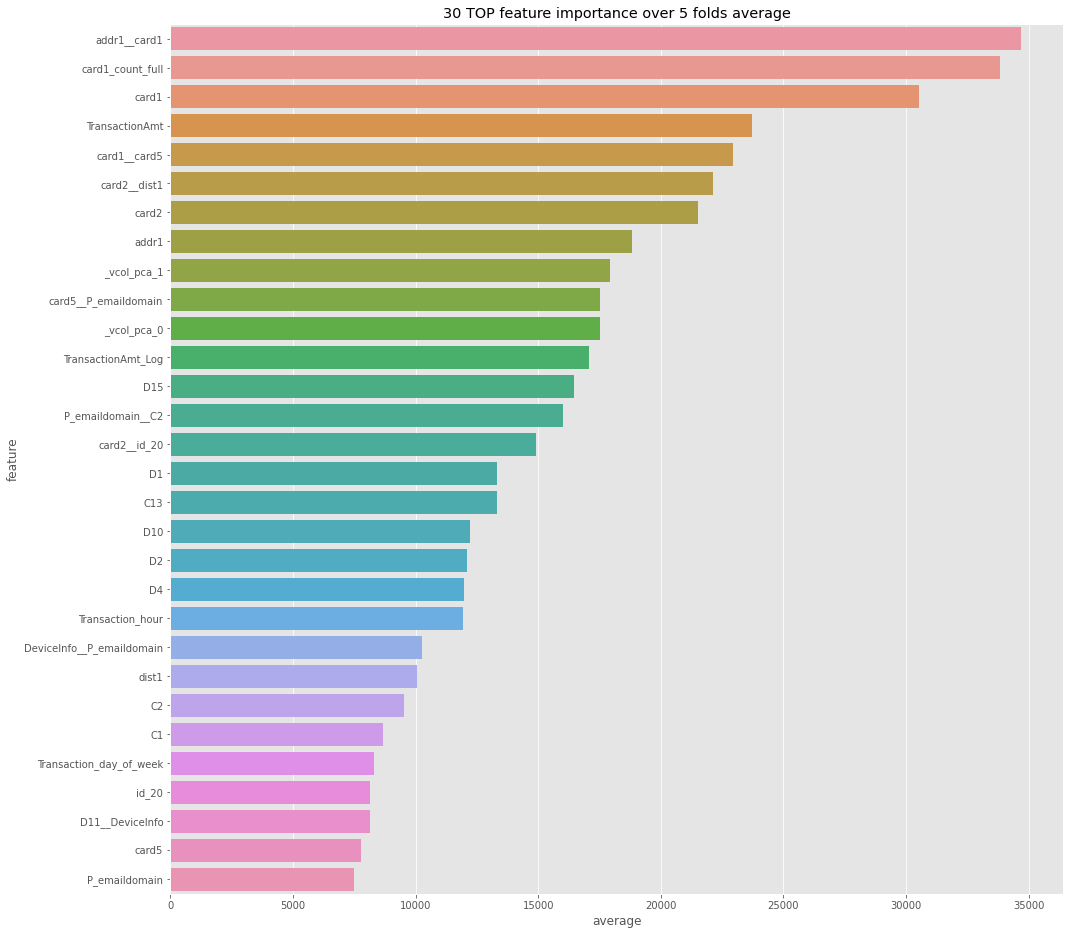

In [57]:
# Best lightGBMC params after further fine-tuning

params = {'num_leaves': 450, 
          'n_estimators': 1500, 
          'min_child_weight': 0.033, #regularization
          'feature_fraction': 0.35, #regularization
          'subsample': 0.35, #regularization
          'bagging_seed': 5059, #reproducibility
          'min_child_samples': 180,  #regularization
          'objective': 'binary',
          'learning_rate': 0.005, 
          'boosting_type': "gbdt", 
          'metric': 'auc',
          'verbosity': -1,
          'reg_alpha': 0.35, #regularization
          'reg_lambda': 0.6, #regularization
          'random_state': 5059 #reproducibility
          }

trained_lgb = train_lgb(X_train, y_train)

In [58]:
trained_lgb.fit(X_train, y_train)
y_preds = trained_lgb.predict_proba(X_test)[:, 1]
sub['isFraud'] = y_preds
sub.to_csv('lgb_best.csv', index=False)

**Final GBMC Score, private 0.913, public 0.940**

![Final Kaggle!](best_lgb.jpg "LightGBMC Final Score")